In [ ]:
!pip install textract
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 106 kB 9.4 MB/s 
     |████████████████████████████████| 111 kB 38.2 MB/s 
     |████████████████████████████████| 69 kB 6.5 MB/s 
     |████████████████████████████████| 5.6 MB 13.6 MB/s 
     |████████████████████████████████| 10.1 MB 17.2 MB/s 
     |████████████████████████████████| 32.8 MB 39 kB/s 
     |████████████████████████████████| 103 kB 47.6 MB/s 
     |████████████████████████████████| 1.9 MB 38.9 MB/s 
     |████████████████████████████████| 128 kB 28.9 MB/s 
     |████████████████████████████████| 73 kB 2.6 MB/s 
     |████████████████████████████████| 112 kB 47.7 MB/s 
     |████████████████████████████████| 149 kB 45.7 MB/s 
     |████████████████████████████████| 70 kB 6.8 MB/s 
     |████████████████████████████████| 339 kB 38.6 MB/s 
  Created wheel for textract: filename=textract-1.6.4-py3-none-any.whl size=22888 sha256=c6e30b1a357a5aeb33cdace54f0223db0f118dcf9f5fc9d4859754c882d187a9
  Stored in directory: /root/.cache/pip/w

     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 42.6 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
     |████████████████████████████████| 3.3 MB 48.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import textract
import re, json, os
from os.path import join
from bs4 import BeautifulSoup
from gensim.summarization import keywords
import warnings
warnings.filterwarnings("ignore")
from transformers import AutoModelWithLMHead, AutoTokenizer

import nltk
import spacy
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')

Data extraction

In [ ]:
def extract_content_from_pdf(filename):
    # text variable which contains all the text derived from our PDF file
    full_text = textract.process(filename, method='pdfminer', language='eng').decode('utf-8')
    return full_text.encode('ascii','ignore').lower().decode('utf-8')

def extract_keyword(full_text):
    keyword_summaries = keywords(text = full_text, split = "\n", scores = True)
    data = pd.DataFrame(keyword_summaries, columns = ["keyword", "score"])
    return data.sort_values("score", ascending = False)

In [ ]:
SEMESTER = "f19"
data_path = "/content/drive/MyDrive/oli/"
oli_org = open(data_path + f'{SEMESTER}/organizations/default/organization.xml', "r").read()
oli_org_soup = BeautifulSoup(oli_org, "lxml")

In [ ]:
def get_module_unit_from_org(page_id):
    try:
        resource_ref = oli_org_soup.find('resourceref', {'idref': page_id})
        curr_module = resource_ref.find_parent('module').find('title').get_text()
        curr_unit = resource_ref.find_parent('unit').find('title').get_text()
        return curr_module, curr_unit
    except:
        return None, None

def is_header(p):
    # a header paragraph should have the form <p><em>...</em></p>, with no other inner tag
    n_contents = len([c for c in p.contents if not str(c.string).isspace()])
    return p.find("em") is not None and n_contents == 1

def get_file_content(filename):
    with open(data_path+f'{SEMESTER}/content/x-oli-workbook_page/' + filename ) as file:
        soup = BeautifulSoup(file.read(), 'lxml')
    page_id = soup.find('workbook_page')['id']
    curr_module, curr_unit = get_module_unit_from_org(page_id)
    title = soup.find("title").get_text().strip()   
    
    # extract the sub-headers <p><em>text</em></p> and remove them from the text content
    sub_headers = []
    for p in soup.find_all("p"):
        if is_header(p):
            sub_headers.append(p.find("em").get_text().strip())
            p.extract()
    
    all_text = "\n".join(p.get_text().strip() for p in soup.find_all("p"))
    all_text = re.sub(r"\n+", r"\n", all_text.strip())
    return {
        "Unit" : curr_unit, "Module" : curr_module, "Title" : title,
        "Text": all_text, "Subheaders" : ",".join(sub_headers)
    }

In [ ]:
df_oli = pd.DataFrame([
    get_file_content(filename)
    for filename in os.listdir(data_path + f"{SEMESTER}/content/x-oli-workbook_page")
    if filename.endswith(".xml")
]).dropna()
df_oli.to_csv("oli_content.csv", index = False)
df_oli.reset_index(inplace=True)
df_oli.head()

,index,Unit,Module,Title,Text,Subheaders
0,0,Exploratory Data Analysis,Feature Engineering,Summary and Quiz 5,"In this module, we explored a technique used t...",
1,1,Analytic Requirements Gathering,Requirements Overview,Types of Requirements,Suppose a utility company wants to introduce p...,"Business Requirements,System and User Requirem..."
2,2,Problem Identification and Solution Vision,Distilling the Analytic Objective,Step 4b: Proposing Data Collection Methods,Just as the methods proposed must be suitable ...,Proposing Datasets & Collection Methods
3,4,Problem Identification and Solution Vision,Distilling the Analytic Objective,Step 5b: Framing Common Forms of Analytical Ob...,Now that you have studied the elements of a pr...,"Constructive,Benchmarking,Exploratory"
4,5,Model Evaluation,Evaluation Metrics,Clustering Evaluation Metrics,The previous page focused on the metrics for e...,


Knowledge Graph Creation

In [ ]:
spacy.explain('dobj')

'direct object'

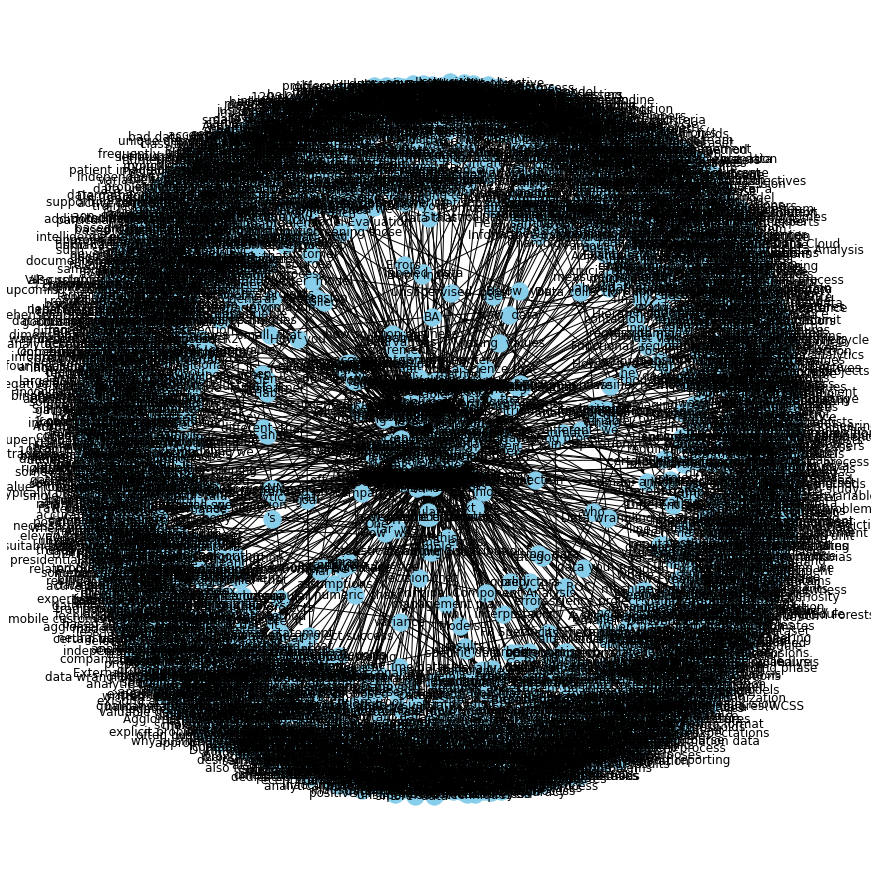

In [ ]:
# Approach One: https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

sentences_list = list(df_oli['Text'])
text_content = " ".join(sentences_list).replace("\n", " ")
sentences = nltk.sent_tokenize(text_content)\

filtered_sentences = list()
relations = list()

for s in sentences:
  filtered_sentences.append(get_entities(s))
  relations.append(get_relation(s))

# Build the actual KG
source = [i[0] for i in filtered_sentences]
target = [i[1] for i in filtered_sentences]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

kg_df.to_csv('knowledge_graph.csv')

G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Keywords

In [ ]:
def get_keywords():
  # Approach 1: Extract from text somehow - custom rules
  # Approach 2: extract_keywords() function from gensim
  # Approach 3: Syntactic parsing
  # Approach 4: External Knowledge Graph
  # Approach 5: Hard-Code
  keywords = ['ranking', 'sampling', 'Feature Engineering', 'Clustering']
  return keywords

Answer generation

In [ ]:
def get_answer(content):
  answers = list()
  keywords = get_keywords()
  for word in keywords:
    if word in content:
      answers.append(word)
  return answers

df_oli['answer'] = df_oli.apply(lambda row : get_answer(row['Text']), axis=1)

Question Generation

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")

def get_question(answer, context, max_length=64):
  input_text = "answer: %s  context: %s </s>" % (answer, context)
  features = tokenizer([input_text], return_tensors='pt')

  output = model.generate(input_ids=features['input_ids'], 
               attention_mask=features['attention_mask'],
               max_length=max_length)

  return tokenizer.decode(output[0])

In [ ]:
def populate_qa_dict(content, answers_list, dictionary):
  for ans in answers_list:
    question = get_question(ans, content)
    dictionary[question] = ans

In [ ]:
qa_pairs = dict()
df_oli.apply(lambda row : populate_qa_dict(row['Text'], row['answer'], qa_pairs), axis=1)

for key in qa_pairs.keys():
  print(key)
  print(qa_pairs[key])
  print("***")